### Imports etc

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pyarrow  # to load parquet file
import utils  # help file with all functions etc.
import os
import pickle
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# interpolated_data = pd.read_excel('data/interpolated_sensors.xlsx')
PLOT_AUTOCORRS = False

FREQ = '5S'
MAX_LAGS_ONE_DIR = 60


Bad key "text.kerning_factor" on line 4 in
C:\Users\brewij\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
interpolated_data = utils.load_interpolated_data()

In [4]:
all_sensors_df = deepcopy(interpolated_data)

# Q2 Sensor Response Times

__Some sensors may respond immediately to a change in a setting (e.g., the spinning frequency of a motor) while others may have a longer response time (e.g., the temperature of the product when the temperature setting of a heat exchanger has been changed). Can you determine the response times of the different sensors? Please explain precisely how you define the response time.__

In [5]:
# we filter out categorical sensors as the slope of these sensors are mostly 0 which our algorithm does not work well with
# This eliminates 15 out of the 65 sensors we started with
all_sensors_df = all_sensors_df.loc[all_sensors_df['UoM'] != 'categorical'].copy()

In [6]:
all_sensors_df['Tag'].unique()

array(['CCUA4846210', 'NLFD6046949', 'IBCD9076387', 'BCNT5607274',
       'CJYY7281535', 'XZWH6517900', 'KUBF4965544', 'ITPL9140030',
       'YQIV8384792', 'WJTY3058662', 'UBDD6270540', 'OLGF7428100',
       'OGXF8790955', 'CVKK2848713', 'FRMT5013249', 'WECE8118101',
       'TPDS7991137', 'OBVY4087560', 'OPTP4622826', 'UEDA3063294',
       'GAOJ1253882', 'FIFW7229404', 'GZBG5070510', 'FRSE9448289',
       'YHUJ9211611', 'RYSR5117035', 'PFQK6744816', 'UVUI8922817',
       'FBNS3444193', 'GQHO3289500', 'DOGW6414031', 'GHWP1757707',
       'VKBD2463131', 'BXWS8009878', 'ACSH9824768', 'WFVO6119956',
       'EACL8267893', 'MJZI2886611', 'JAAM9433816', 'TJLA6041869',
       'UUFO3180241', 'VOJU5732246', 'MZWG6597875', 'OJGX2105018',
       'SINT4409168', 'GJWD1249502', 'KKSV5218886', 'SKGH6792105',
       'DYPZ7187588', 'KGFQ7639756'], dtype=object)

### Step 1: calculate the derivative (differencing) for every sensor separately, at every timestamp.
- This ensures the delta peaks can be tackled as we can later on filter out the top x % rows.

In [7]:
sensor_types = list(all_sensors_df['UoM'].unique())
derivatives_df = pd.DataFrame()

for sens_type in sensor_types:
    deriv_df = utils.get_derivative_per_sensortype(sensor_type = sens_type, interpolated_df=all_sensors_df, column_names = list(all_sensors_df.columns),reset_index=True)
    derivatives_df = derivatives_df.append(deriv_df)

### Visualization function
- Plot visualization to substantiate the report and interpret what is happening at every step 

In [8]:
def sensor_compare_series_plot(sensor: str, df1: pd.DataFrame, df2: pd.DataFrame, column1:str, column2:str,  min_time= '2020-06-12 00:00:00', max_time='2020-06-14 00:00:00') -> None:
    """
    Plots any two time series from two defined dataframes. These dataframes and columns might even be the same as it just plots the column that is given with the Timestamp as index.
    Also, the time window for which the time series should be plotted is to be provided as parameter. By default, the entire 48 hours of data are plotted.
    """
    
    
    frame1 = df1.loc[(df1['Tag'] == sensor) & (df1['TS'] < max_time) & (df1['TS'] > min_time)]
    frame1 = frame1.set_index('TS')
    frame1[column1].plot()
    plt.show()
    

    frame2 = df2.loc[(df2['Tag'] == sensor) & (df2['TS'] < max_time) & (df2['TS'] > min_time)]
    frame2 = frame2.set_index('TS')
    frame2[column2].plot()
    plt.show()

#### Some visualizations

In [9]:
sensor_df = derivatives_df.loc[derivatives_df['Tag'] == 'CJYY7281535']

In [10]:
sensor_df = utils.filterout_top_rows(0.05, sensor_df)

C:\Users\brewij\Projects\DDFVC\sensorAssignment\utils.py:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_df['_slope'] = np.where(np.isin(sensor_df['slope'], top_rows), 'NaN', sensor_df['slope'])


##### Plot the effect of delta peak removal 

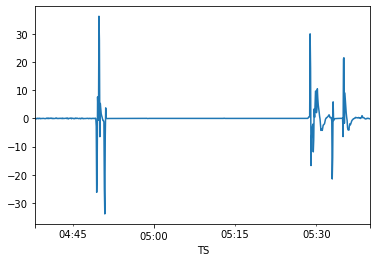

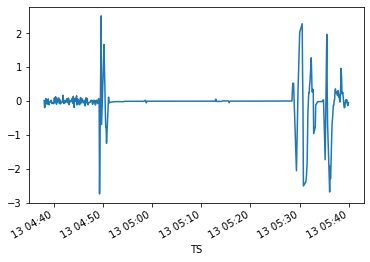

In [11]:
sensor_compare_series_plot('CJYY7281535', derivatives_df, sensor_df, column1 = 'slope', column2='slope', min_time= '2020-06-13 04:38:00', max_time='2020-06-13 05:40:00')

#### Visualize difference between squared- and normal partial autocorrelation results for 1 sensor

In [36]:
sensor = 'CJYY7281535'
frame = derivatives_df
percent = 0.05

# filter initial dataframe on locking only rows of the sensor in question
sensor_df = frame.loc[frame['Tag'] == sensor].copy()

# filter out top rows
filtered_sensor_df = utils.filterout_top_rows(percent, sensor_df)


autocorr_df = utils.calc_sensor_autocorelation(sensor, filtered_sensor_df, MAX_LAGS_ONE_DIR
                                               ,data_col='avg')


response_time, autocorrelated_df =  utils.get_response_time_sensor(autocorr_df)

In [37]:
autocorrelated_df

,auto_corr,Lag,Tag,squared_autocorr,distribution,Probability_*_Lag
1,0.947391,1,CJYY7281535,8.975504e-01,9.632067e-01,9.632067e-01
2,-0.097197,2,CJYY7281535,9.447255e-03,1.013833e-02,2.027665e-02
3,0.001725,3,CJYY7281535,2.976396e-06,3.194121e-06,9.582363e-06
4,0.005043,4,CJYY7281535,2.542758e-05,2.728763e-05,1.091505e-04
5,0.031151,5,CJYY7281535,9.704008e-04,1.041386e-03,5.206931e-03
6,0.081936,6,CJYY7281535,6.713573e-03,7.204675e-03,4.322805e-02
7,0.084354,7,CJYY7281535,7.115646e-03,7.636160e-03,5.345312e-02
8,0.045513,8,CJYY7281535,2.071455e-03,2.222983e-03,1.778386e-02
9,0.022612,9,CJYY7281535,5.112848e-04,5.486856e-04,4.938170e-03
10,0.006325,10,CJYY7281535,4.000747e-05,4.293404e-05,4.293404e-04


In [40]:
autocorrelated_df[['Lag', 'Tag', 'auto_corr', 'squared_autocorr', 'distribution', 'Probability_*_Lag' ]]

,Lag,Tag,auto_corr,squared_autocorr,distribution,Probability_*_Lag
1,1,CJYY7281535,0.947391,8.975504e-01,9.632067e-01,9.632067e-01
2,2,CJYY7281535,-0.097197,9.447255e-03,1.013833e-02,2.027665e-02
3,3,CJYY7281535,0.001725,2.976396e-06,3.194121e-06,9.582363e-06
4,4,CJYY7281535,0.005043,2.542758e-05,2.728763e-05,1.091505e-04
5,5,CJYY7281535,0.031151,9.704008e-04,1.041386e-03,5.206931e-03
6,6,CJYY7281535,0.081936,6.713573e-03,7.204675e-03,4.322805e-02
7,7,CJYY7281535,0.084354,7.115646e-03,7.636160e-03,5.345312e-02
8,8,CJYY7281535,0.045513,2.071455e-03,2.222983e-03,1.778386e-02
9,9,CJYY7281535,0.022612,5.112848e-04,5.486856e-04,4.938170e-03
10,10,CJYY7281535,0.006325,4.000747e-05,4.293404e-05,4.293404e-04


In [39]:
autocorr_df

,auto_corr,Lag,Tag,squared_autocorr,distribution,Probability_*_Lag
1,0.947391,1,CJYY7281535,8.975504e-01,9.632067e-01,9.632067e-01
2,-0.097197,2,CJYY7281535,9.447255e-03,1.013833e-02,2.027665e-02
3,0.001725,3,CJYY7281535,2.976396e-06,3.194121e-06,9.582363e-06
4,0.005043,4,CJYY7281535,2.542758e-05,2.728763e-05,1.091505e-04
5,0.031151,5,CJYY7281535,9.704008e-04,1.041386e-03,5.206931e-03
6,0.081936,6,CJYY7281535,6.713573e-03,7.204675e-03,4.322805e-02
7,0.084354,7,CJYY7281535,7.115646e-03,7.636160e-03,5.345312e-02
8,0.045513,8,CJYY7281535,2.071455e-03,2.222983e-03,1.778386e-02
9,0.022612,9,CJYY7281535,5.112848e-04,5.486856e-04,4.938170e-03
10,0.006325,10,CJYY7281535,4.000747e-05,4.293404e-05,4.293404e-04


##### Plot the partial autocorrelation

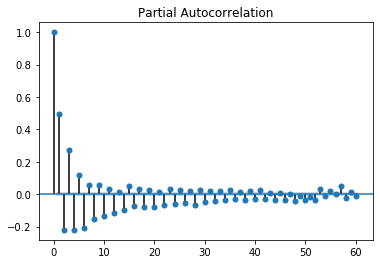

In [13]:
tmp_df = utils.get_one_ts(smoothend_df = derivatives_df,
                          sensor = 'CJYY7281535', data_col='slope'
                         )
plot_pacf(x=tmp_df, 
         lags=MAX_LAGS_ONE_DIR,
         alpha=0.05);
plt.show()

##### Plot the Squared Partial Autocorrelation

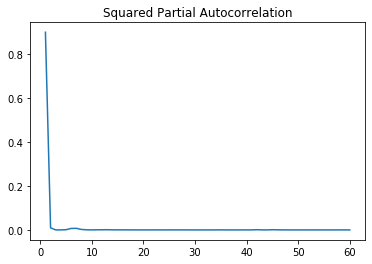

In [14]:
autocorr_df.set_index('Lag')
autocorr_df['squared_autocorr'].plot(title='Squared Partial Autocorrelation')


## Response time function
- All other steps of the algorithm are combined in the __calc_response_time_sensor__ function in the __utils__ file. In the utils file all functions are well-documented so for further details please open that document.

Most code and functions that this notebook uses for the calculation of sensor response times are stored in the 'utils.py' file which can be found in the same folder as this notebook.
The reason for using this utils file is to enable the reuse of functions and code to any notebook that uses the centralized utils.py file. Simply importing that file allows for easily reusing functions in the respective notebook.

#### Response time function

In [15]:
def get_all_sensor_response_times(deriv_df, percent, MAX_LAGS_ONE_DIR):
    """
    # DESCRIPTION
    This function calculates the response times of every sensor in the provided dataframe.
    For this calculation the calc_response_time_sensor function is used for every sensor.
    All response times are added to a single dataframe

    # PARAMETERS


    # RETURNS
    A dataframe with the response time per sensor!!


    """
    sensor_response_times_df = pd.DataFrame(columns={'Sensor', 'ResponseTime'})

    all_unique_sensors = deriv_df['Tag'].unique().tolist()
    print(len(all_unique_sensors))
    for sensor in all_unique_sensors:

        try:
            frame = deriv_df.loc[deriv_df['Tag'] == sensor].copy()

            response_time, sensor = utils.calc_response_time_sensor(sensor, frame, MAX_LAGS_ONE_DIR, percent)

            sensor_response_times_df = sensor_response_times_df.append(
                {'ResponseTime': response_time, 'Sensor': sensor}, ignore_index=True)
        except:
            pass

    return sensor_response_times_df

In [16]:
sensor_response_times_df = get_all_sensor_response_times(derivatives_df, 0.05, MAX_LAGS_ONE_DIR)

50


In [17]:
sensor_response_times_df

,ResponseTime,Sensor
0,28.535209,CCUA4846210
1,16.365861,YQIV8384792
2,16.418933,WJTY3058662
3,16.342326,UBDD6270540
4,16.342274,OGXF8790955
5,16.417699,WECE8118101
6,20.125897,TPDS7991137
7,20.094305,OBVY4087560
8,20.111315,OPTP4622826
9,20.103235,UEDA3063294


##### Plot the sensor response times in a scatter plot

Text(0, 0.5, 'Response Time in Seconds')

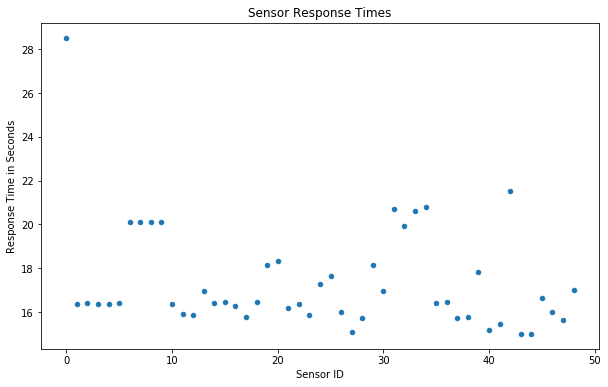

In [18]:
time_plot = sensor_response_times_df.reset_index().plot(x='index', y='ResponseTime', title='Sensor Response Times', kind='scatter', figsize=(10,6))
time_plot.set_xlabel("Sensor ID")
time_plot.set_ylabel("Response Time in Seconds")

#### Save response times dataframe as pickle file 

In [19]:
# save reponse time dataframe as pickle file
utils.save_responsetime_df(sensor_response_times_df)

In [20]:
# save response time dataframe as excel file such that output can be more easily put into a table in our report.
sensor_response_times_df.to_excel('data/response_times.xlsx')